In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
from scipy import fftpack
import seaborn as sns
style.use('seaborn')

In [ ]:
def rename_column(df,prefix):
    column_name = list(df.columns)
    column_name = [prefix + name for name in column_name]
    return df.set_axis(column_name, axis=1)

In [ ]:
target_set = pd.read_csv(".\\bearing_classes.csv",sep=";")
origin_set = pd.read_csv(".\\bearing_signals.csv")

In [62]:
origin_set

,experiment_id,bearing_1_id,bearing_2_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,hz,w
0,1,0,1,0.000000,0.113269,0.149706,-0.110275,-0.186030,0.194450,0.454299,0.000000,0.000000,0.000006
1,1,0,1,0.000333,-0.367713,-0.228832,0.177821,0.285992,0.002226,-0.043930,0.000000,0.000000,0.000243
2,1,0,1,0.000667,0.113269,0.149706,-0.398371,-0.091625,0.002226,0.454299,0.000000,0.000000,0.000369
3,1,0,1,0.001000,-0.175320,-0.228832,-0.110275,0.285992,0.002226,0.255007,0.000000,0.000000,0.000520
4,1,0,1,0.001333,-0.079124,0.055072,-0.110275,0.191588,0.002226,0.255007,0.000000,0.000000,0.000175
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10265695,112,0,112,32.098333,-0.367713,0.149706,0.465916,-0.469243,0.194450,0.553945,178.748759,2.979146,0.019412
10265696,112,0,112,32.098667,-0.463909,0.338975,0.561948,-0.469243,0.194450,0.354653,178.748759,2.979146,0.032027
10265697,112,0,112,32.099000,0.017072,0.433610,0.369884,-0.563647,-0.093886,0.155361,178.748759,2.979146,0.012211
10265698,112,0,112,32.099333,0.209465,0.244341,0.273852,-0.374838,0.194450,0.155361,178.748759,2.979146,0.000764


In [ ]:
exp_set = origin_set.drop(['experiment_id','bearing_1_id','rpm','hz','w', 'timestamp'],axis=1)

In [90]:
#def by_bearing(df):
number_bearing = exp_set['bearing_2_id'].max()
new_set = exp_set[exp_set['bearing_2_id'] == 80]
df_bearing_1_x = new_set.drop(['bearing_2_id','a2_x','a2_y','a2_z','a1_y','a1_z'], axis = 1)
w = fftpack.fft(df_bearing_1_x)
freqs = fftpack.fftfreq(len(w))
idx = np.argmax(np.abs(w))
freq = freqs[idx]
freq_in_hertz = abs(freq * 1/3)
print(idx)
""" new_set = pd.DataFrame(freqs)
print(new_set) """
""" 
for i in range(2,number_bearing+1):
    new_var = exp_set[exp_set['bearing_2_id'] == i]
    new_var = fftpack.fft(new_var)
    new_var = pd.DataFrame(new_var)
    new_set = pd.concat([new_set,new_var],axis=0)
new_set = new_set.set_axis(['bearing_2_id', 'a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z'], axis=1)
new_set['bearing_2_id'] = exp_set['bearing_2_id'] """


37914


" \nfor i in range(2,number_bearing+1):\n    new_var = exp_set[exp_set['bearing_2_id'] == i]\n    new_var = fftpack.fft(new_var)\n    new_var = pd.DataFrame(new_var)\n    new_set = pd.concat([new_set,new_var],axis=0)\nnew_set = new_set.set_axis(['bearing_2_id', 'a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z'], axis=1)\nnew_set['bearing_2_id'] = exp_set['bearing_2_id'] "

In [ ]:
w = np.fft.fft(data)
freqs = fftpack.fftfreq(len(w))
print(freqs.min(), freqs.max())
# (-0.5, 0.499975)

# Find the peak in the coefficients
idx = np.argmax(np.abs(w))
freq = freqs[idx]
freq_in_hertz = abs(freq * 0.001/3)
print(freq_in_hertz)
# 439.8975

In [ ]:
bearing_1 = new_set[new_set['bearing_2_id']==1]

KeyboardInterrupt: 

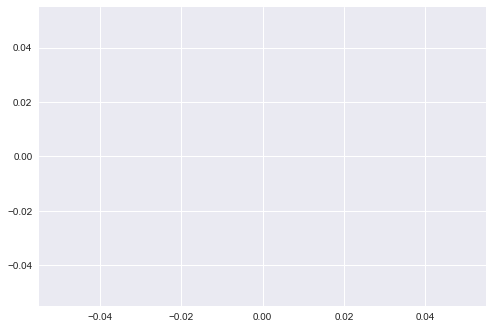

In [61]:
x = [ele.real for ele in bearing_1['a1_x']]
# extract imaginary part
y = [ele.imag for ele in bearing_1['a1_x']]
  
# plot the complex numbers
plt.plot(x, y)
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.show()

In [ ]:
max_fft_set = new_set.groupby(['bearing_2_id']).max()
max_fft_set = rename_column(max_fft_set,"fft_max_")

In [ ]:
exp_set.columns

In [ ]:
max_set = exp_set.groupby(['bearing_2_id']).max()
max_set = rename_column(max_set,"max_")
min_set = exp_set.groupby(['bearing_2_id']).min()
min_set = rename_column(min_set,"min_")
mean_set = exp_set.groupby(['bearing_2_id']).mean()
mean_set = rename_column(mean_set,"mean_")
std_set = exp_set.groupby(['bearing_2_id']).std()
std_set = rename_column(std_set,"std_")
sum_set = exp_set.groupby(['bearing_2_id']).sum()

In [ ]:
df = pd.concat([min_set,max_set,mean_set,std_set,max_fft_set],axis=1)
df['target']= target_set.iloc[1:,1]

In [ ]:
#df = df.drop('min_timestamp',axis=1)
df

In [ ]:
X = df.drop('target',axis=1)
y = df['target']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [ ]:
param_grid = {
    'n_estimators':[200,150,100,50],
    'criterion':['gini','entropy'],
    'max_depth':[2,4,6,8]
}

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

Model_rf = RandomForestClassifier(random_state=41)
grid = GridSearchCV(estimator=Model_rf, param_grid=param_grid, n_jobs=-1)
grid.fit(X_train, y_train)
Model_rf = grid.best_estimator_
y_pred_train = Model_rf.predict(X_test)
training_data_accuracy_rf = accuracy_score(y_test, y_pred_train)

In [ ]:

print("The accuracy of RandomForestC Model is", (training_data_accuracy_rf*100), '%')
print('The Cross Validation Rapport : ','\n', (classification_report(y_test, y_pred_train)))

In [ ]:
rf = RandomForestClassifier(criterion='entropy', max_depth=6)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(accuracy_score(y_pred, y_test))
y_train_pre = rf.predict(X_train)
print(accuracy_score(y_train_pre, y_train))

In [ ]:
scores = cross_val_score(rf, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Accuracy_score", accuracy_score(y_train_pre, y_train))
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())
print("Variation:", scores.var())

In [ ]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(Model_rf.feature_importances_,3)})
importances1 = importances.sort_values('importance',ascending=False).set_index('feature')
importances1.plot(kind='bar',figsize=(15,6))